In [1]:
cd ../..

/home/dvibert/work/FireBallPipe.git


In [2]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2

import sys
import numpy as np
from astropy.io import fits
from astropy import wcs, coordinates
from astropy import units as u
from astropy.wcs.utils import proj_plane_pixel_scales
from matplotlib import pyplot as plt
from astropy.table import Table, vstack 
import matplotlib.patches as patches
import unittest
from mpl_interactions import heatmap_slicer
import pandas as pd
import datetime 
# os.chdir(os.path.dirname(os.path.realpath(__file__)))
sys.path.insert(1, './Calibration')
from guider2UV.guider2UV import Guider2UV, diff_skycoord, fit_model, plot_fit
from guider2UV.guider2UV import coord_list_to_array
from Calibration.mapping import Mapping

In [3]:
G2UV = Guider2UV(filename='Notebook/2018/data_needed_to_run_notebooks/F2_180901.pkl')
print(G2UV)

FOV center angular position in guider <SkyCoord (SkyOffsetICRS: rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39837843, 36.42897653)>): (lon, lat) in deg
    [(0.18496501, -0.02412983)]>
FOV center pixel position in guider [array([1366.06657564]), array([431.55331128])]

Guider2UV object:
    Local Field Projector: 
ScienceMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=-20.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (253.0624, 34.9699)>)>
    gamma: 0.9970115643897801

    Guider Field Projector: 
GuiderMaskProjector object:
    LocalFrame: <SkyOffsetICRS Frame (rotation=0.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
    (250.39837843, 36.42897653)>)>
    wcs: WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 250.39837843  36.4289765325  
CRPIX : 640.0  540.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.00024600287745946  0.00024580474694405  
NAXIS : 0  0

    mask_rotation:

In [4]:
target_filename = 'Calibration/Targets/targets_F2.csv'
F2 = Table.read(target_filename, format='ascii')

In [5]:
F2['RA'].name='ra'
F2['DEC'].name='dec'

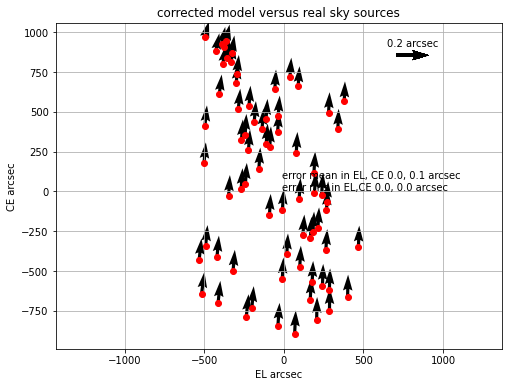

In [6]:
G2UV.FieldP.gamma = 1.
slit_coords_all, source_coords_all = G2UV.compare_mask_2_sky(F2['Internal-count'], F2, quiverscale=0.2)

In [7]:
source_coords_all

[<SkyCoord (SkyOffsetICRS: rotation=-20.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (253.0624, 34.9699)>): (lon, lat) in deg
     (-0.1008865, 0.26217771)>,
 <SkyCoord (SkyOffsetICRS: rotation=-20.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (253.0624, 34.9699)>): (lon, lat) in deg
     (-0.10882042, 0.25720344)>,
 <SkyCoord (SkyOffsetICRS: rotation=-20.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (253.0624, 34.9699)>): (lon, lat) in deg
     (-0.10478414, 0.25223043)>,
 <SkyCoord (SkyOffsetICRS: rotation=-20.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (253.0624, 34.9699)>): (lon, lat) in deg
     (-0.11882232, 0.24510608)>,
 <SkyCoord (SkyOffsetICRS: rotation=-20.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (253.0624, 34.9699)>): (lon, lat) in deg
     (-0.09114295, 0.24080472)>,
 <SkyCoord (SkyOffsetICRS: rotation=-20.0 deg, origin=<ICRS Coordinate: (ra, dec) in deg
     (253.0624, 34.9699)>): (lon, lat) in deg
     (-0.09977136, 0.23280

## compare approx of field centering (ie without whole spherical rotation)

In [8]:
lon = (F2['ra'] - origin.ra.value) * np.cos(origin.dec.to(u.rad).value)
lat = F2['dec'] - origin.dec.value

# rotation
rot = 20*np.pi/180.
mat_rot= np.array([[np.cos(rot), np.sin(rot)],[-np.sin(rot), np.cos(rot)]])

coord_arr = np.array([lon,lat]).T

coord_arr = mat_rot.dot(coord_arr.T).T
source_coord_arr = coord_list_to_array(source_coords_all)


NameError: name 'origin' is not defined

Text(-10, 7, 'error mean in EL, CE -0.5, -0.1 arcsec\nerror rms in EL,CE 0.6, 0.1 arcsec')

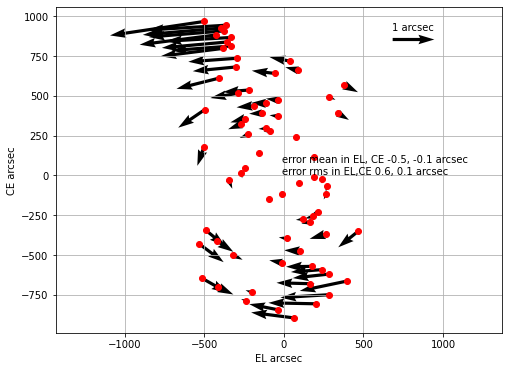

In [ ]:

delta = coord_arr - source_coord_arr

quiverscale = 1
plt.figure(figsize=(8,6))
plt.axis('equal')
plt.plot(coord_arr[:,0]*3600, coord_arr[:,1]*3600,'or')
#if labels is not None:
#    for i in range(len(coord_arr)):
#        plt.text(coord_arr[i,0]*3600, coord_arr[i,1]*3600, labels[i], color='k')
qv = plt.quiver(coord_arr[:,0]*3600, coord_arr[:,1]*3600, delta[:,0]*3600, delta[:,1]*3600)
plt.quiverkey(qv, .8,.9, quiverscale, f'{quiverscale} arcsec', color='k')
#plt.ylim(plt.ylim()[::-1])
plt.grid(True)
plt.xlabel('EL arcsec')
plt.ylabel('CE arcsec')
delta_mean = delta.mean(axis=0)
delta_rms = np.sqrt(np.square(delta - delta_mean).mean(axis=0))*3600
delta_mean *= 3600
legend =  "error mean in EL, CE {:.1f}, {:.1f} arcsec\n".format(*list(delta_mean))
legend += "error rms in EL,CE {:.1f}, {:.1f} arcsec".format(*list(delta_rms))
plt.text(-10,7, legend)


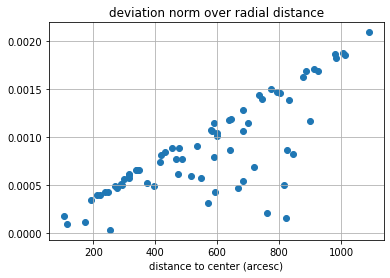

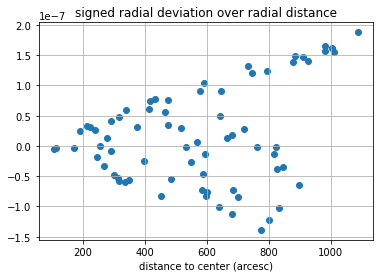

In [ ]:
radius = np.sqrt( np.square(source_coord_arr).sum(axis=1) )*3600
delta = (coord_arr - source_coord_arr)*3600
delta_norm = np.sqrt( np.square(coord_arr- source_coord_arr).sum(axis=1))*3600
delta_dot_radius = np.einsum('...j,...j', delta, source_coord_arr)/radius

   
plt.figure()
plt.scatter(radius, np.array(delta_norm)/np.array(radius))
plt.xlabel('distance to center (arcesc)')
plt.title('deviation norm over radial distance')
plt.grid(True)
#plt.ylim((0.0006,0.001))

plt.figure()
plt.scatter(radius, np.array(delta_dot_radius)/np.array(radius))
plt.xlabel('distance to center (arcesc)')
plt.title('signed radial deviation over radial distance')
plt.grid(True)
#plt.ylim((0.0006,0.001))

## check max deviation of UV mapping vs linear platescale

In [ ]:
mask_det_map_file = "Calibration/Mappings/2022/mask_to_det_mapping/mapping-mask-det-w-2022-5-%s_-60.pkl"%('F1')
mask_det_map = Mapping(mask_det_map_file)

obs_wave = 0.20619 #0.2139

In [ ]:
det_center = mask_det_map.map(obs_wave, 0 ,0)
Jxy_inv  = mask_det_map.inv_mapping.jacobian((obs_wave, det_center[0], det_center[1]))[:,1:]

In [ ]:
slits_coord_obs_det = np.array([
[1420.2,593.9	],
# [?     ,?	],
[2039.1,965.9	],
[1479.7,1706.4	],
[1530.3,826.6	],
[1529.5,825.49511	],
[1479.4,1708.3128	],
[2039.4,966.49409	],
# [?     ,	?	],
[1419.5,594.50322	]])

In [ ]:

#inv_map(obs_wave, coord_det[:, 0], coord_det[:, 1]).T
#lambda w, x, y: self.mask_det_map.inv_map(w, x - offsets[0], y - offsets[1])
    
slits_coord_obs = mask_det_map.inv_map(obs_wave, slits_coord_obs_det[:,0], slits_coord_obs_det[:,1]).T / 42.26134 # deg

slits_coord_obs_linear =Jxy_inv.dot((slits_coord_obs_det-mask_det_map.map(obs_wave, 0., 0.)).T).T / 42.26134 # deg
slits_coord_obs, slits_coord_obs_linear

(array([[ 0.12642581, -0.08846266],
        [ 0.01269212,  0.12917962],
        [-0.21339373, -0.06963619],
        [ 0.05538549, -0.04954289],
        [ 0.05572227, -0.0498253 ],
        [-0.21398146, -0.06975483],
        [ 0.01250853,  0.12928489],
        [ 0.12623896, -0.08870649]]),
 array([[ 0.12686144, -0.08778727],
        [ 0.01309038,  0.12909722],
        [-0.21381442, -0.06719312],
        [ 0.05562638, -0.04924404],
        [ 0.05596455, -0.04952424],
        [-0.21440027, -0.06729875],
        [ 0.01290852,  0.12920225],
        [ 0.12667654, -0.08803282]]))

[[ 1.56828377  2.43138482]
 [ 1.4337453  -0.29663777]
 [-1.51448028  8.79508133]
 [ 0.86720403  1.07586134]
 [ 0.87219004  1.08381706]
 [-1.50771193  8.84191329]
 [ 1.43998278 -0.2974974 ]
 [ 1.57529531  2.42522274]]
[2.8932933  1.4641105  8.92452274 1.38185399 1.39117752 8.96953878
 1.47039284 2.89193027]


Text(-10, 7, 'error mean in EL, CE 0.6, 3.0 arcsec\nerror rms in EL,CE 1.2, 3.5 arcsec')

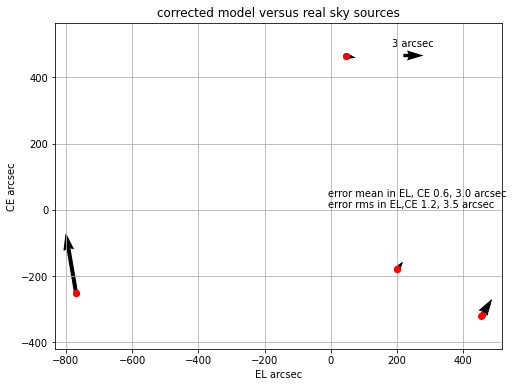

In [ ]:
delta = slits_coord_obs_linear - slits_coord_obs
print(delta*3600)
print(np.sqrt(np.square(delta).sum(axis=1))*3600)

quiverscale = 3
plt.figure(figsize=(8,6))
plt.axis('equal')
plt.title("corrected model versus real sky sources")
plt.plot(slits_coord_obs[:,0]*3600, slits_coord_obs[:,1]*3600,'or')
#if labels is not None:
#    for i in range(len(coord_arr)):
#        plt.text(coord_arr[i,0]*3600, coord_arr[i,1]*3600, labels[i], color='k')
qv = plt.quiver(slits_coord_obs[:,0]*3600, slits_coord_obs[:,1]*3600, delta[:,0]*3600, delta[:,1]*3600)
plt.quiverkey(qv, .8,.9, quiverscale, f'{quiverscale} arcsec', color='k')
#plt.ylim(plt.ylim()[::-1])
plt.grid(True)
plt.xlabel('EL arcsec')
plt.ylabel('CE arcsec')
delta_mean = delta.mean(axis=0)
delta_rms = np.sqrt(np.square(delta - delta_mean).mean(axis=0))*3600
delta_mean *= 3600
legend =  "error mean in EL, CE {:.1f}, {:.1f} arcsec\n".format(*list(delta_mean))
legend += "error rms in EL,CE {:.1f}, {:.1f} arcsec".format(*list(delta_rms))
plt.text(-10,7, legend)


In [ ]:
target_filename = 'Calibration/Targets/2022/targets_F1.csv'
F1 = Table.read(target_filename, format='ascii')

In [ ]:
coord_det = mask_det_map.map(obs_wave, F1['x_mm'], F1['y_mm']).T
slits_coord_obs = mask_det_map.inv_map(obs_wave, coord_det[:,0], coord_det[:,1]).T / 42.26134 # deg
slits_coord_obs_linear =Jxy_inv.dot((coord_det - mask_det_map.map(obs_wave, 0., 0.)).T).T / 42.26134 # deg

Text(-10, 7, 'error mean in EL, CE -0.0, 4.8 arcsec\nerror rms in EL,CE 2.7, 4.1 arcsec')

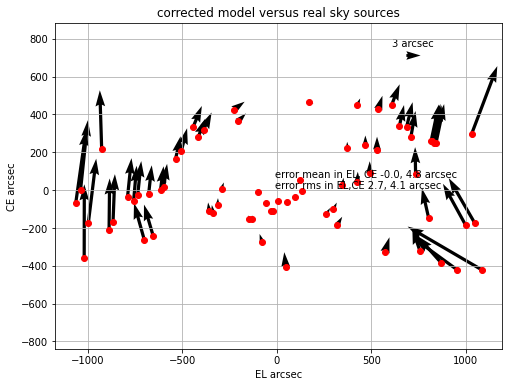

In [ ]:
delta = slits_coord_obs_linear - slits_coord_obs
#print(delta*3600)
#print(np.sqrt(np.square(delta).sum(axis=1))*3600)

quiverscale = 3
plt.figure(figsize=(8,6))
plt.axis('equal')
plt.title("corrected model versus real sky sources")
plt.plot(slits_coord_obs[:,0]*3600, slits_coord_obs[:,1]*3600,'or')
#if labels is not None:
#    for i in range(len(coord_arr)):
#        plt.text(coord_arr[i,0]*3600, coord_arr[i,1]*3600, labels[i], color='k')
qv = plt.quiver(slits_coord_obs[:,0]*3600, slits_coord_obs[:,1]*3600, delta[:,0]*3600, delta[:,1]*3600)
plt.quiverkey(qv, .8,.9, quiverscale, f'{quiverscale} arcsec', color='k')
#plt.ylim(plt.ylim()[::-1])
plt.grid(True)
plt.xlabel('EL arcsec')
plt.ylabel('CE arcsec')
delta_mean = delta.mean(axis=0)
delta_rms = np.sqrt(np.square(delta - delta_mean).mean(axis=0))*3600
delta_mean *= 3600
legend =  "error mean in EL, CE {:.1f}, {:.1f} arcsec\n".format(*list(delta_mean))
legend += "error rms in EL,CE {:.1f}, {:.1f} arcsec".format(*list(delta_rms))
plt.text(-10,7, legend)
